In [52]:
import scvelo as scv
#import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
# from RKHS import SparseVFC
# from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix
import hotspot
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD

from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import CompleteKPartiteGraph,AttributedGraph,GraphDataset,Encoder,\
                            level_sets,train_test_split,reset_seeds

import seaborn as sns
from scipy.stats import gaussian_kde

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())

data_path = 'data/'
data_name = 'DG_bin'
# data_name = 'DG_new'
# data_name = 'A549_emt_bin'
# data_name = 'zebrafish_dynamo_part'
# data_name = 'neural_bin'
# adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
#adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
pca_dim = 50
[k_nei, K, L] = [10, 3, 6]
    
# new_para_name = 'PCA'
# new_para_name = 'eigengene'  
new_para_name = 'hotspot'
# new_para_name = ''

# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'
method = ''

cmap = plt.colormaps['Spectral']

import os


2.3.0
None
False
0


In [53]:
import umap

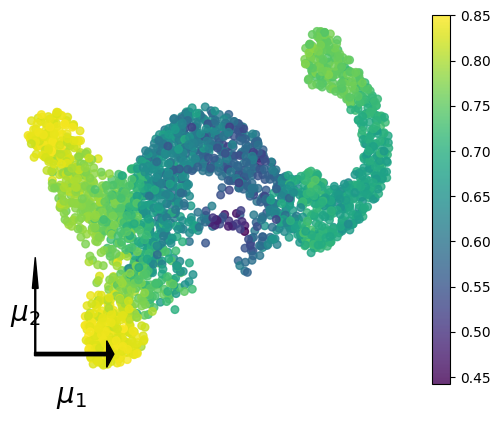

In [54]:
data_path='data/'
#data_name = 'BoneMarrow/human_cd34_bone_marrow.h5ad'
data_name = 'EG_ab_dyn.h5ad'
# data_name = '20DG_data.h5ad'
#data_name = 'processed bonemarrow.h5ad'
#data_name = 'lung.h5ad'
#data_name = 'DentateGyrus/DentateGyrus.loom'
# data_name = 'zebrafish_dynamo_part.h5ad'
adata0=scv.read(data_path+data_name, cache=True)

model_name = 'EG_ab_dyn'
#model_name = 'processed bonemarrow'
#model_name = 'lung'
# model_name = 'DentateGyrus'
# model_name = 'zebrafish'

subfolder = 'weighted'
result_path = 'results/'+model_name+'/'+subfolder+'/' +f'k_nei={k_nei}/K={K} L={L}/' +f'{new_para_name}_critical/'
import os
folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)

# k_nei = 20
# #-------data preprocessing
# while True:

#     #adata=adata0.copy()
#     scv.pp.neighbors(adata0, n_neighbors=k_nei)
#     scv.pp.moments(adata0, n_pcs=50, n_neighbors=k_nei)
#     zero_gene_num = np.sum(np.sum(adata0.layers['Ms'],axis=0) == 0)
#     print('zero_gene_num',zero_gene_num)
#     if zero_gene_num == 0:
#         lowvar_num = np.sum(np.var(adata0.layers['Ms'],0)<1e-1)
#         print('lowvar_num',lowvar_num)
#         if lowvar_num == 0:
#             break
#         else:
#             adata0 = adata0[:,(np.var(adata0.layers['Ms'],0)>1e-1)]
#     else:
#         adata0 = adata0[:,(np.sum(adata0.layers['Ms'],axis=0) != 0)]

# scv.pp.pca(adata0,n_comps=50)

# scv.tl.velocity(adata0)
# scv.tl.velocity_graph(adata0)
# scv.tl.velocity_pseudotime(adata0)

 ###读存储数据
# K,L = 3,6
read_path = 'results/'+model_name+'/'+f'{subfolder}/k_nei={k_nei}/'#+ f'k_nei={k_nei}/'
para = f'K={K} L={L}/'
# para = ''
Xs = np.load(read_path+'X'+'.npy')
X_pca = np.load(read_path+'X_pca'+'.npy')
cell_nei = np.load(read_path+'cell_nei'+'.npy')
nei_w = np.load(read_path+'nei_w'+'.npy')
color_label = np.load(read_path+'color_label'+'.npy')
encoder = torch.load(read_path+para+'encoder'+'.pt')
Fisher_g = np.load(read_path+para+'Fisher_g'+'.npy')
crc_smooth = np.load(read_path+para+'crc_smooth'+'.npy')
crc_eu = np.load(read_path+para+'crc_eu'+'.npy')
k_nei=cell_nei.shape[1]
n = Xs.shape[0]

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

def Fisher_dist_new(mu1, sigma1, mu2, sigma2):
    dmu = (mu1 - mu2) / np.sqrt(2)
    sigma_sum = sigma1 + sigma2
    sigma_diff = sigma1 - sigma2
    
    a = np.sqrt(dmu**2 + sigma_sum**2) + np.sqrt(dmu**2 + sigma_diff**2)
    b = np.sqrt(dmu**2 + sigma_sum**2) - np.sqrt(dmu**2 + sigma_diff**2)
    
    dF2 = 2 * np.sum(np.log(a / b)**2)
    return np.sqrt(dF2)

def wasserstein_distance_new(mu1, sigma1, mu2, sigma2):
    dmu = mu1 - mu2
    W_dist2 = np.sum(dmu**2 + sigma1**2 + sigma2**2 - 2 * np.sqrt(sigma2 * sigma1**2 * sigma2))
    return np.sqrt(W_dist2)

def Jacobian_nn_new(x0, encoder):
    x = torch.tensor(x0, requires_grad=True)
    
    # Compute the Jacobian for both outputs in the encoder
    z=encoder(x)

    jacobian = torch.autograd.functional.jacobian(z, x)
    
    # Split the jacobian into two parts
    d = jacobian.shape[0] // 2
    pMu_pX = jacobian[:d]
    pSgm_pX = jacobian[d:]
    
    return pMu_pX.numpy(), pSgm_pX.numpy()


###############读数据
read_path = 'results/'+model_name+'/'+f'{subfolder}/'+ f'k_nei={k_nei}/'
para = f'K={K} L={L}/'
Xs = np.load(read_path+'X'+'.npy')
X_pca = np.load(read_path+'X_pca'+'.npy')
cell_nei = np.load(read_path+'cell_nei'+'.npy')
nei_w = np.load(read_path+'nei_w'+'.npy')
color_label = np.load(read_path+'color_label'+'.npy')
encoder = torch.load(read_path+para+'encoder'+'.pt')
Fisher_g = np.load(read_path+para+'Fisher_g'+'.npy')
crc_smooth = np.load(read_path+para+'crc_smooth'+'.npy')
crc_eu = np.load(read_path+para+'crc_eu'+'.npy')
cell_vpt=color_label
X=Xs

###读存储数据numpy版本导致clusters读取失败运行这段代码
np.load.__defaults__ =(None, True, True, 'ASCII')
clusters = np.load(read_path+'clusters'+'.npy')
clusters_PAGA = np.load(read_path+'clusters_PAGA'+'.npy')
# gene_arr = np.load(read_path+para+'gene_arr'+'.npy')
np.load.__defaults__ =(None, False, True, 'ASCII')

###读存储数据
X_plt = np.load(read_path+'X_plt'+'.npy')
Y_plt = np.load(read_path+'Y_plt'+'.npy')
##坐标 和 伪时间图

X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min+5*wid
Y_ori = Y_min+5*wid

plt.scatter(X_plt,Y_plt,s=30,alpha=0.8,c=crc_smooth,cmap='viridis')
plt.colorbar()
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid*1.5,color='black',head_width=12*wid,head_length=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid*2/3,color='black',head_width=4*wid,head_length=14*wid)

plt.text(X_ori+X_len/2,Y_ori-wid*22,'$\mu_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*7,Y_ori+Y_len/2,'$\mu_2$',fontsize=20,ha='center',weight='bold')

# plt.savefig(result_path+model_name+'_mu.png',dpi=600,bbox_inches='tight')
plt.show()

In [55]:
#######要跑
adata=adata0.copy()
# velo0 = np.array(adata.layers['velocity'])
# velo_g = np.zeros(velo0.shape)
# velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
# velo_pca = velo_g@adata.varm['PCs']
# #latent_z = np.hstack((mu_learned,sigma_learned))

In [56]:
##
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()
latent_z = np.hstack((mu_learned,sigma_learned))

In [57]:
import sklearn
print(sklearn.__version__)

1.4.2


In [58]:
#------use a simple neural network to study dmu/dt and dsigma/dt
def new_para(X,latent_z):
    np.random.seed(42)
    x_in = torch.tensor(X)
    pca_dim = x_in.shape[1]
    model = nn.Sequential(
        nn.Linear(pca_dim, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,2*L),
    )

    # Define your loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    x_out=torch.tensor(latent_z.astype(np.float32))
    # Train the model
    for epoch in range(200):  # number of epochs
        # Forward pass
        output = model(x_in)
        loss = loss_fn(output,x_out) 
    #     if epoch% 10 == 9:
    #         print(epoch,loss)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    pZ_pX = np.zeros([X.shape[0], L*2, X.shape[1]])

    # Compute the gradients
    for i in range(X.shape[0]):
        x0=torch.tensor(X[i,:],requires_grad=True)
        z=model(x0)
        for j in range(2*L):
            x0.grad = None       
            z[j].backward(retain_graph=True)
            pZ_pX[i,j,:] = x0.grad.detach()
            

    return model,pZ_pX[:,:L,:],pZ_pX[:,L:,:]

In [59]:
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        pca=PCA(n_components=5).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_.T)
    #        eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w

def eigen_gene_hs(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        if i < 0:
            continue
        pca=PCA(n_components=2).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_[0,:])
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w

def compute_x_eigen(X):
    global eigen_X,eigen_X_w
    X_corr=np.corrcoef(X, rowvar=False)
    plt.imshow(X_corr)
    plt.colorbar()
    plt.show()

    Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
    dg=dendrogram(Z)
    X_re= X[:,dg['leaves']]#X_re reorder X by clustering

    X_corr_re=np.corrcoef(X_re, rowvar=False)
    plt.show()

    td = 0.996
    T = fcluster(Z, t=td, criterion='distance')
    # T=fcluster(Z, t=td, criterion='maxclust')
    T_re = T[dg['leaves']]

    plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')
    plt.show()

    X_corr_label = np.zeros(X_corr_re.shape)
    for i in range(X_corr_re.shape[0]):
        label_ind = np.where(T_re==T_re[i])[0]
        X_corr_label[i,label_ind] = 1

    plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.gray, interpolation='nearest',origin='lower')
    plt.colorbar()
    plt.show()


    eigen_X,eigen_X_w=eigen_gene(X_re,T_re)
    eigen_dim=len(np.unique(T_re))
    n_eigen = 1
    cell_eigen_X = eigen_X[0,:,:n_eigen]
    for i in range(eigen_dim-1):
        cell_eigen_X = np.hstack((cell_eigen_X,eigen_X[i+1,:,:n_eigen]))
    return cell_eigen_X

def compute_x_hs(X):
    global hs_X, hs_X_w
    # Create the Hotspot object and the neighborhood graph
    # hotspot works a lot faster with a csc matrix!
    hs = hotspot.Hotspot(
        adata, 
        model='danb',
        distances_obsp_key = 'distances'
    )

    hs.create_knn_graph(
        weighted_graph=False, n_neighbors=k_nei,
    )

    hs_results = hs.compute_autocorrelations(jobs=1)

    # Select the genes with significant lineage autocorrelation
    hs_genes = hs_results.loc[hs_results.FDR < 0.1].sort_values('Z', ascending=False).head(800).index

    # Compute pair-wise local correlations between these genes
    lcz = hs.compute_local_correlations(hs_genes, jobs=1)

    modules = hs.create_modules(
        min_gene_threshold=10, core_only=True, fdr_threshold=0.1
    )

    modules.value_counts()
    # np.save(result_path+'modules', modules.values)
    # np.save(result_path+'hs_genes', hs_genes)

    adata_hs = adata[:,hs_genes] # 只用hotspot有效的gene
    T_hs = np.array(hs.modules.tolist()) # 记录所有hs gene的module

    scaler = StandardScaler()
    X_hs = scaler.fit_transform(adata_hs.layers['Ms'])
    hs_X, hs_X_w = eigen_gene(X_hs,T_hs)
    hs_dim=len(hs_X_w)

    cell_hs_X=np.zeros((X_hs.shape[0],hs_dim))
    for j in range(X_hs.shape[0]):
        for k in range(len(hs_X_w)):
            cell_hs_X[j,k]=np.dot(hs_X_w[k],X_hs[j,T_hs==k+1])


    return cell_hs_X

In [60]:
read_path

'results/EG_ab_dyn/weighted/k_nei=10/'

In [62]:
if new_para_name == 'PCA':
    X = X_pca
    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)
if new_para_name == 'eigengene':
    X = compute_x_eigen(X)
    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)
if new_para_name == 'hotspot':
    cell_hs_X = np.load(read_path+'cell_hs_X'+'.npy')
    X = cell_hs_X.astype(np.float32)
    # X = compute_x_hs(X)
    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)

In [63]:

cl_name = np.unique(clusters)
palette = sns.color_palette("RdBu_r",n_colors=cl_name.shape[0])
# palette = sns.color_palette(n_colors=cl_name.shape[0])
cln = np.array(clusters)
cl_vpt = np.zeros(cl_name.shape[0])
for i in range(cl_name.shape[0]):
    if data_name=='DG_bin':
        cl_vpt[i] = np.mean(cell_vpt[cln==cl_name[i]])
    else:
        cl_vpt[i] = np.mean(cell_vpt[cln==cl_name[i]])
cl_vpt_ind = np.argsort(cl_vpt)
cl_name_vpt = cl_name[cl_vpt_ind]

cln_vpt_ind = np.zeros(cln.shape[0],dtype=int)
clx = np.zeros(cln.shape[0])
clc = np.array([palette[0]]*cln.shape[0])
cl_ind = np.zeros(cl_name.shape[0])
i_ind = 0
for i in range(cl_name.shape[0]):
    cli_ind = np.argwhere(cln==cl_name_vpt[i])[:,0]
    ni = cli_ind.shape[0]
    cln_vpt_ind[i_ind:i_ind+ni] = cli_ind
    clx[cli_ind] = i
    clc[cli_ind] = palette[i]
    cl_ind[i] = i_ind+ni/2
    i_ind += ni
cln_vpt = cln[cln_vpt_ind]

In [64]:
from utils import *
velo = np.load(read_path+'velocity'+'.npy')

In [65]:
##原始基因空间的导数，直接使用Gaussian embedding 的神经网络
if new_para_name == '':
    pMu_pX = np.zeros([X.shape[0],L,X.shape[1]])
    pSgm_pX = np.zeros([X.shape[0],L,X.shape[1]])
    for i in range(X.shape[0]):
        pMu_pX[i],pSgm_pX[i] = Jacobian_nn(X[i],L,encoder)
        # pMu_pX[i],pSgm_pX[i] = Jacobian_nn_new(X[i],L,encoder)
# mu_velo = np.array([pMu_pX[i]@velo[i] for i in range(X.shape[0])])
# sgm_velo = np.array([pSgm_pX[i]@velo[i] for i in range(X.shape[0])])
# zv2 = np.zeros(X.shape[0])
# for i in range(X.shape[0]):
#     for j in range(L):
#         zv2[i] += Fisher_g[i,j,j]*mu_velo[i,j]**2 + Fisher_g[i,L+j,L+j]*sgm_velo[i,j]**2
# zv1 = np.sqrt(zv2)
# zv1_smooth = smooth_func(zv1)

In [66]:
# #-------------transcription factors analysis
# df = pd.read_csv(data_path+'gene lists/mouse_TF_list.csv')
# TF = df['Symbol'].values
# adata=adata0.copy()
# for ti in range(len(TF)):
#     TF[ti] = TF[ti].upper()
# gene_list = np.array([x.upper() for x in adata.var.index.values])
# tf_inds = np.where(np.in1d(gene_list,TF))[0]
# non_tf_inds = np.where(~np.in1d(gene_list,TF))[0]
# tf_gene = adata.var.index.values[tf_inds]
# print(len(tf_inds))

In [67]:
Fisher_g.shape

(2322, 12, 12)

In [68]:
###gene FI and stiff gene
stiffnum = np.zeros(X.shape[0])##number of stiffgene |(n,1)
# tf_stiffnum = np.zeros(X.shape[0])
pZ_pX = np.zeros([X.shape[0], L*2, X.shape[1]])
diagFIgene = np.zeros((X.shape[0],X.shape[1])) ##Fisher information of gene |(n,m)
Eigenvec = np.zeros((X.shape[0],X.shape[1]))   ##1st eigenvec for each cell |(n,m)
Eigenval = []  ##前2特征值 | (n,2)
for i in range(X.shape[0]):
    pZ_pX[i] = np.vstack((pMu_pX[i],pSgm_pX[i]))
    FIgene_i = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]
    Eigenval.append([np.linalg.eigh(FIgene_i)[0][-1],np.linalg.eigh(FIgene_i)[0][-2]])
    Eigenvec[i] = np.linalg.eigh(FIgene_i)[1][:,-1]
    diagFIgene[i] = np.diag(FIgene_i)
    FI_max = np.array([np.argmax(FIgene_i[j]) for j in range(X.shape[1])])
    # tf_max = np.array([np.argmax(FIgene_i[tf_inds][:,tf_inds][j]) for j in range(len(tf_inds))])
    stiffnum[i] = len(np.unique(list(FI_max)))
    # tf_stiffnum[i] = len(np.unique(list(tf_max)))

In [69]:
Eigenval = np.array(Eigenval)
Eigenval.shape

(2322, 2)

In [70]:
print('平均前二特征值差距倍数：',np.mean(Eigenval[:,0]/Eigenval[:,1]))
print('最大前二特征值差距倍数：',np.max(Eigenval[:,0]/Eigenval[:,1]))
print('最小前二特征值差距倍数：',np.min(Eigenval[:,0]/Eigenval[:,1]))
print('Eigenvec.shape',Eigenvec.shape)

平均前二特征值差距倍数： 135.71203993973432
最大前二特征值差距倍数： 1057.9443446763323
最小前二特征值差距倍数： 6.144253041635439
Eigenvec.shape (2322, 5)


In [71]:
import seaborn as sns

palette1 = sns.color_palette('bright')
palette2 = sns.color_palette('pastel')
c1 = tuple((np.array(palette1[0])+np.array(palette1[-1]))/2)
c2 = tuple((np.array(palette2[0])+np.array(palette2[-1]))/2)

Eigen gene direction

In [72]:
clusters0 = clusters
clusters = adata.obs['clusters'] ##在这行是之后使用的细胞聚类方法，可以自行更换比如PAGA
categories = np.unique(clusters)
eigenvec={}
for i in categories:
    eigenvec[i] = Eigenvec[clusters==i]

In [73]:
def PLT_box(clusters,matrix,save_path,ylabel,title_name='violin',xlabel='cell_type',cell_sort=None):
    categories = list(set(clusters[np.argsort(color_label)]))
    if cell_nei is None:
        None
    else:
        categories.sort(key = list(clusters[np.argsort(cell_sort)]).index)
    eigenvalues = {}
    for i in categories:
        eigenvalues[i] = matrix[clusters==i]
    plt.figure()
    #plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
    for j in range(matrix.shape[1]):
        plt.boxplot([eigenvalues[i][:,j] for i in list(eigenvalues)])
    # 设置x轴的标签
    #plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
    plt.xticks(range(1,len(categories)+1),categories)
    if np.sum([len(i) for i in categories])>50:
        plt.xticks(rotation=40)
    # 添加标题和标签
    plt.title(title_name,fontsize=16,weight='bold')
    plt.xlabel(xlabel,fontsize=14,weight='bold')
    plt.ylabel(ylabel,fontsize=14,weight='bold')
    plt.savefig(save_path,dpi=300, bbox_inches='tight')
    plt.show()

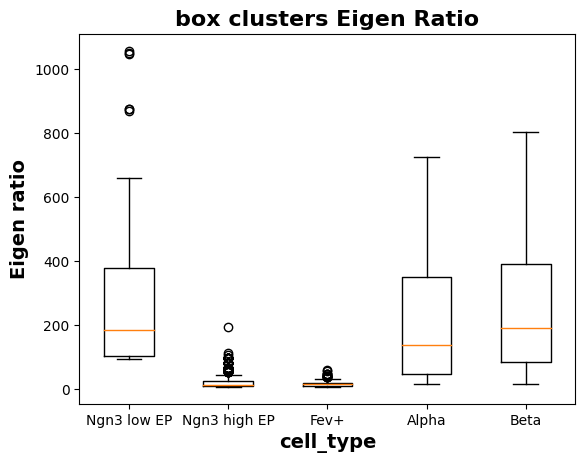

In [74]:
##画图，前2特征值比值图
PLT_box(clusters,(Eigenval[:,0]/Eigenval[:,1]).reshape((X.shape[0],1)),save_path=result_path+f'box Eigen Ratio {new_para_name}'+'.png',
           ylabel='Eigen ratio',title_name='box clusters Eigen Ratio',cell_sort=cell_vpt)

In [75]:
for i in categories:
    print(f'{i}平均前二特征值差距倍数：',np.mean((Eigenval[:,0]/Eigenval[:,1])[clusters==i]))
    print(f'{i}最大前二特征值差距倍数：',np.max((Eigenval[:,0]/Eigenval[:,1])[clusters==i]))
    print(f'{i}最小前二特征值差距倍数：',np.min((Eigenval[:,0]/Eigenval[:,1])[clusters==i]))

Alpha平均前二特征值差距倍数： 229.18114314966493
Alpha最大前二特征值差距倍数： 726.3642314118655
Alpha最小前二特征值差距倍数： 16.409453771166095
Beta平均前二特征值差距倍数： 248.72836155573188
Beta最大前二特征值差距倍数： 805.535241871622
Beta最小前二特征值差距倍数： 16.666724325275602
Fev+平均前二特征值差距倍数： 15.714552984016615
Fev+最大前二特征值差距倍数： 58.770950485866145
Fev+最小前二特征值差距倍数： 6.714616522972243
Ngn3 high EP平均前二特征值差距倍数： 24.698526997677344
Ngn3 high EP最大前二特征值差距倍数： 192.395799468372
Ngn3 high EP最小前二特征值差距倍数： 6.144253041635439
Ngn3 low EP平均前二特征值差距倍数： 264.6052637307707
Ngn3 low EP最大前二特征值差距倍数： 1057.9443446763323
Ngn3 low EP最小前二特征值差距倍数： 94.3137150450536


In [76]:
for i in categories:
    print(i,len(Eigenvec[clusters==i]))

Alpha 477
Beta 591
Fev+ 587
Ngn3 high EP 529
Ngn3 low EP 138


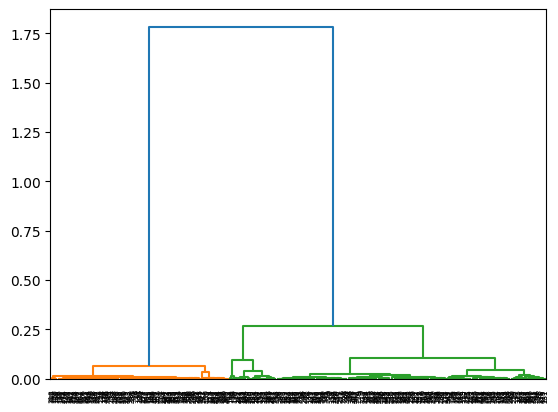

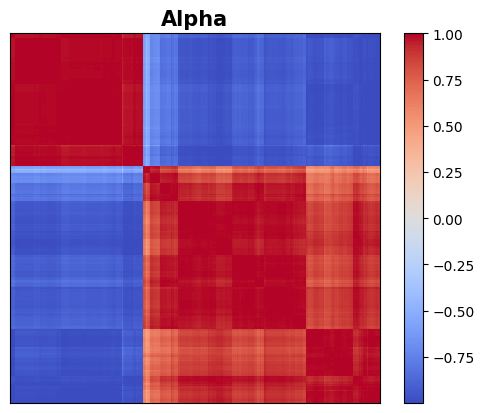

[2 1 1 2 2 2 2 1 1 2 1 1 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 1
 1 1 2 1 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 1 2 2 2 1 2 2 2 2 1 1 2 1 2 1 2 1 2
 1 2 1 1 2 2 2 2 2 2 2 2 1 2 2 1 1 1 2 2 1 1 1 2 2 1 2 1 1 1 2 2 2 1 1 2 2
 2 2 2 2 2 1 1 1 2 2 2 1 1 2 1 2 2 2 2 1 2 2 1 2 2 2 2 2 2 1 1 2 2 2 2 2 2
 2 2 2 2 1 1 2 1 1 2 1 2 2 2 2 1 1 1 2 2 2 2 2 2 1 2 2 1 2 2 1 1 2 2 2 2 1
 1 2 1 1 2 1 1 2 2 2 2 1 2 2 1 1 2 2 1 1 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 2 2
 2 2 1 2 1 1 2 1 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 1 1 1 2 1 2 2
 1 2 2 1 2 1 2 2 1 2 2 1 2 1 1 2 2 1 1 2 1 1 2 2 2 2 2 2 2 1 1 2 2 2 2 1 2
 2 2 2 2 2 1 1 1 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 1 2 1 2 2 1 1 1 1
 2 1 2 1 1 2 2 1 2 1 2 2 2 1 2 2 2 2 2 1 2 1 2 1 2 2 2 2 1 2 1 1 1 2 1 2 2
 2 2 2 2 2 2 2 2 1 2 1 2 1 2 1 2 2 2 2 2 2 2 1 2 2 1 2 1 2 2 1 2 2 2 1 2 1
 1 2 1 2 2 2 2 1 2 2 2 1 1 2 2 1 2 1 2 2 1 2 2 1 2 2 1 2 1 1 1 2 2 2 2 1 2
 1 1 1 2 2 1 2 2 2 1 1 2 2 1 1 1 1 1 2 2 1 2 2 2 2 2 2 1 1 1 1 2 2]


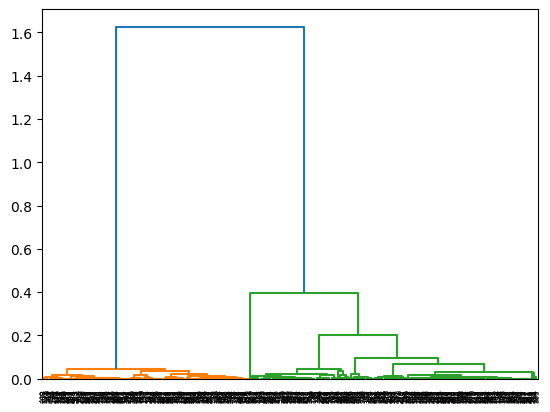

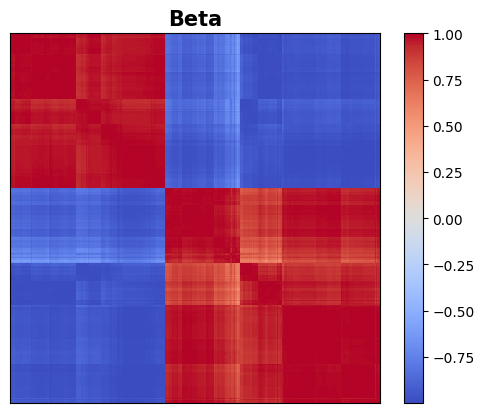

[2 1 2 2 1 1 2 1 2 1 2 1 1 2 2 1 1 1 2 2 2 2 2 1 2 2 1 2 1 2 1 2 2 1 2 1 1
 2 2 1 1 1 2 1 2 2 1 2 2 2 2 2 2 2 2 1 1 1 2 2 1 2 1 1 1 1 1 1 2 1 2 2 2 1
 1 2 2 2 2 1 1 2 2 2 2 1 2 1 1 2 2 2 1 1 1 1 1 2 2 1 2 2 2 1 2 2 1 2 2 1 2
 1 2 2 1 1 2 2 1 2 2 1 1 1 2 1 2 2 1 2 1 2 1 1 2 1 2 1 2 2 2 2 2 1 2 2 1 2
 2 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 2 2 1 2 2 2 1 1 2 2 1 2 2 1 2 1 2 2 2 2 2
 2 2 1 1 1 1 1 2 1 2 2 1 2 1 1 2 1 2 2 1 1 2 1 2 2 2 2 2 2 1 2 2 1 2 2 2 2
 2 2 2 2 2 1 1 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 2 2 2 1 1 2 2
 1 2 1 1 1 1 1 2 2 1 1 1 2 2 1 2 2 2 2 1 1 1 1 1 1 2 1 2 1 1 1 1 2 2 1 1 2
 1 2 2 1 2 2 2 2 2 1 1 1 2 2 1 1 2 2 1 2 2 1 2 1 2 1 2 2 1 2 1 2 2 2 1 2 2
 1 1 1 2 2 1 2 2 1 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 1 1 1 1 2 1 1 1 2 2 1
 1 1 1 1 2 1 2 2 1 1 2 1 2 1 2 2 1 2 2 1 2 1 2 2 1 2 1 1 2 1 1 2 2 2 2 1 2
 1 2 1 2 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 1 1 2 1 2 1 1 2 1 1
 2 2 1 2 1 1 1 1 2 2 2 1 2 2 1 1 2 1 2 2 2 2 2 2 1 2 2 2 1 2 1 2 1 2 1 1 1
 1 2 1 1 2 1 2 1 2 2 1 2 

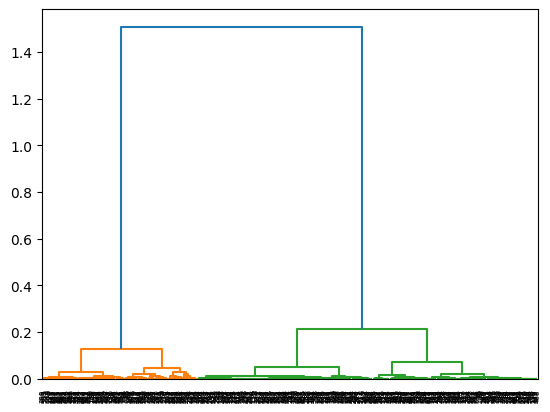

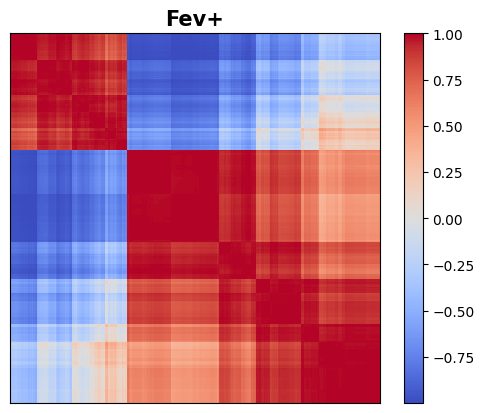

[2 1 1 1 2 1 2 2 2 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 1
 2 2 1 2 1 1 2 2 2 2 2 1 2 1 1 2 2 1 2 2 2 2 1 2 2 2 1 1 1 2 1 2 2 1 1 2 2
 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 1 2 2 2 2 1 1 2 2 2 2 2 1 2 2 1 2 1
 1 2 1 1 2 1 2 2 2 2 1 2 1 2 2 2 1 1 2 1 1 2 2 2 1 2 1 2 2 2 2 2 1 2 2 2 2
 2 1 2 2 2 2 2 2 1 2 1 1 2 2 2 2 2 2 1 1 1 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2
 1 1 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 1 1 2 2 2 1 1 1 1 2 2 1
 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 1 1 2 2 2 2 1 2 1 2 2 1 2
 2 2 1 1 2 2 1 1 2 1 1 1 2 2 2 2 1 1 1 2 2 1 1 2 2 2 1 2 2 2 2 2 2 2 1 2 2
 1 2 2 1 2 1 2 1 2 1 2 1 2 2 2 1 1 2 1 1 2 2 2 1 1 2 2 1 2 1 2 2 2 1 2 2 2
 1 2 1 2 1 2 1 2 2 2 2 2 1 1 1 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2
 1 1 2 2 2 2 1 2 1 1 2 1 2 1 1 2 2 2 2 2 2 1 1 2 2 1 2 2 2 2 2 2 2 1 2 2 1
 1 2 1 1 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 2 1 1 2 2 2 2 1 2 2 1 2 1 2 1 2 1 2 2 2 2 2 2 2 1 1 1 2 1 2 2 2 2 2 1
 1 1 1 2 2 2 2 1 2 2 2 1 

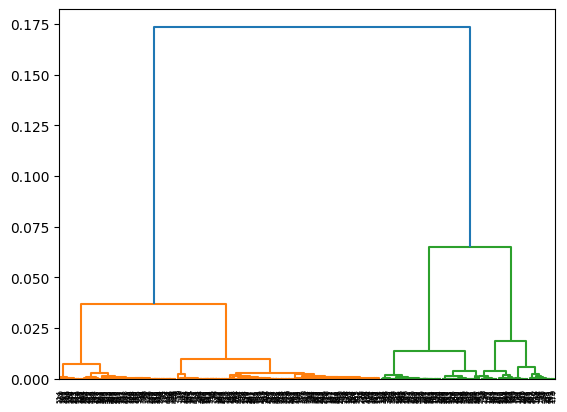

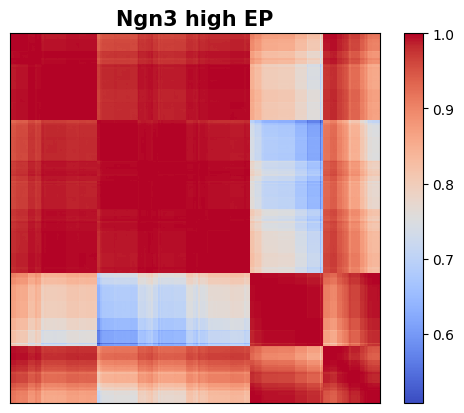

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

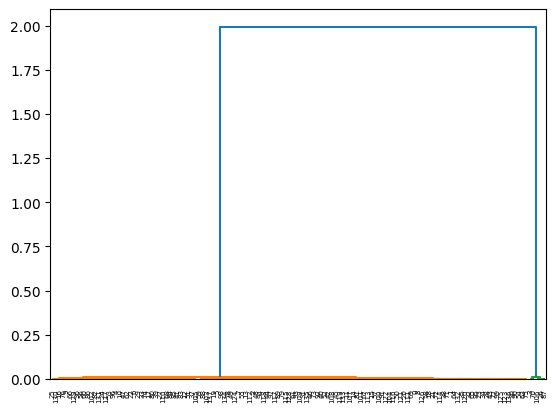

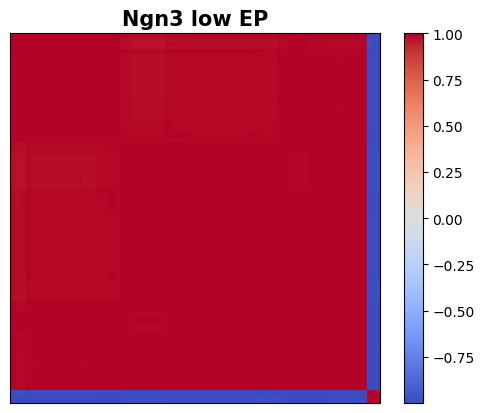

[1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [77]:
###Before optimize the cosdistance
for i in range(len(categories)):
    cl_cat = categories[i]
    vec_corr = eigenvec[cl_cat]@eigenvec[cl_cat].T
    
    Z=linkage((1-vec_corr)[np.triu_indices(vec_corr.shape[0],k=1)],method='weighted')#method='weighted')
    dg=dendrogram(Z)
    #X_re= X[:,dg['leaves']]#X_re reorder X by clustering
    plt.show()
    
    vec_corr_re = vec_corr[dg['leaves'],:][:,dg['leaves']]
    plt.imshow(vec_corr_re, aspect='equal', cmap=plt.cm.coolwarm, interpolation='nearest')
    plt.title(categories[i],fontsize=15,weight='bold')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.savefig(result_path+f'Corr of {categories[i]}.png')
    plt.show()

    # xcos = np.linspace(0,1,100)
    # plt.plot(xcos,gaussian_kde(vec_corr.flatten())(xcos))
    # plt.title(categories[i],fontsize=15,weight='bold')
    # plt.show()
    
    T = fcluster(Z, t=0.9, criterion='distance')
    print(T)

In [78]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB ##去官网申请权限
def GRBopt(Eigenvec):
    n = len(Eigenvec)
    np.random.seed(42)
    X = Eigenvec@Eigenvec.T
    # Create model
    m = gp.Model("binary_quadratic")

    # Create binary variables (will be transformed to {-1,1})
    b = m.addVars(n, vtype=GRB.BINARY, name="b")

    # Set objective: min sum_{i,j} c_i c_j x_{ij}
    # where c_i = 2b_i - 1 transforms binary variables to {-1,1}
    obj = gp.QuadExpr()
    for i in range(n):
        for j in range(n):
            # Expand (2b_i - 1)(2b_j - 1)x_{ij}
            obj += -4 * X[i,j] * b[i] * b[j]  # quadratic term
            obj += 2 * X[i,j] * b[i]        # linear terms
            obj += 2 * X[i,j] * b[j]
            obj += -X[i,j]                    # constant term

    m.setObjective(obj, GRB.MINIMIZE)

    # Optimize
    m.optimize()

    # Extract solution
    if m.status == GRB.OPTIMAL:
        # Convert binary solution back to {-1,1}
        c = [2 * b[i].x - 1 for i in range(n)]
        print("Optimal solution found:")
        print("c =", c)
        print("Objective value =", m.objVal)
        return c
    else:
        print("No optimal solution found")


In [79]:
##调整完方向的eigenvector
eigenvec={}
for i in categories:
    c = GRBopt(Eigenvec[clusters == i])
    eigenvec[i] = np.diag(c)@Eigenvec[clusters==i]

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 9600X 6-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 0 rows, 477 columns and 0 nonzeros
Model fingerprint: 0x9cf0b468
Model has 114003 quadratic objective terms
Variable types: 0 continuous, 477 integer (477 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e+02, 5e+02]
  QObjective range [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -17971.18400
Found heuristic solution: objective -209329.6286
Presolve time: 0.11s
Presolved: 0 rows, 477 columns, 0 nonzeros
Presolved model has 113526 quadratic objective terms
Variable types: 0 continuous, 477 integer (477 binary)

Root relaxation: cutoff, 951 iterations, 0.19 seconds (0.49 work units)

    Nodes    |    Current Nod

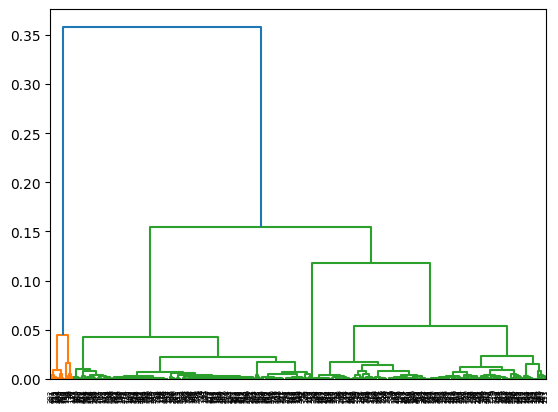

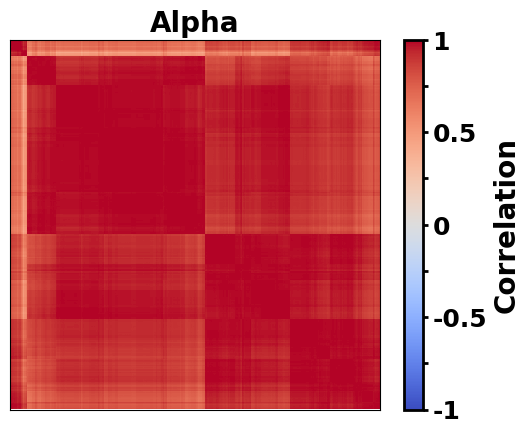

[3 3 2 3 3 3 3 2 2 3 3 2 2 2 3 2 2 2 2 3 2 3 2 3 2 3 3 2 1 3 3 3 2 2 3 2 3
 2 2 3 2 3 3 2 3 3 3 3 2 2 2 2 3 2 3 3 2 2 2 3 2 3 3 3 3 2 2 3 2 3 2 2 2 3
 2 2 2 2 3 3 3 3 3 1 3 3 2 3 2 2 2 2 3 3 3 2 2 1 3 2 2 2 2 2 3 2 3 2 2 3 2
 3 3 3 2 3 2 2 2 2 1 2 2 3 1 3 3 3 2 2 2 2 2 2 3 2 3 3 3 3 2 2 3 3 3 2 2 3
 1 1 3 3 2 2 1 2 2 2 2 1 3 3 3 2 2 2 2 3 3 3 3 3 2 1 3 2 1 3 2 2 2 3 3 3 2
 2 3 2 2 3 2 2 3 2 1 2 2 3 3 2 3 2 3 2 2 2 3 2 3 2 3 2 2 3 2 2 2 2 3 3 3 3
 3 2 2 3 2 2 3 2 3 3 2 3 3 3 3 3 3 2 3 2 3 3 1 2 1 3 2 2 3 3 2 2 2 3 2 2 3
 2 3 3 2 3 3 3 2 2 2 2 2 2 2 3 3 1 2 2 3 2 2 2 2 3 2 3 3 2 3 3 1 3 1 3 2 3
 3 3 3 3 3 2 2 2 2 2 3 3 2 2 3 1 3 3 3 2 2 2 2 3 3 2 3 3 2 3 3 2 3 3 2 2 2
 3 2 2 2 4 3 3 2 3 2 3 2 3 2 3 3 2 3 2 2 3 2 3 2 3 2 3 2 3 2 2 2 2 2 3 3 2
 3 3 3 2 2 3 1 2 2 2 2 3 2 3 2 3 3 3 2 1 2 3 2 3 3 3 3 2 3 3 2 1 3 2 2 1 3
 2 3 3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 2 2 2 2 3 3 2 3 3 3 3 2 2 2 2 3 3 2 2 2
 2 3 2 2 3 2 3 3 3 3 2 3 3 2 2 2 2 2 3 3 2 2 3 3 3 3 3 2 2 2 3 2 2]


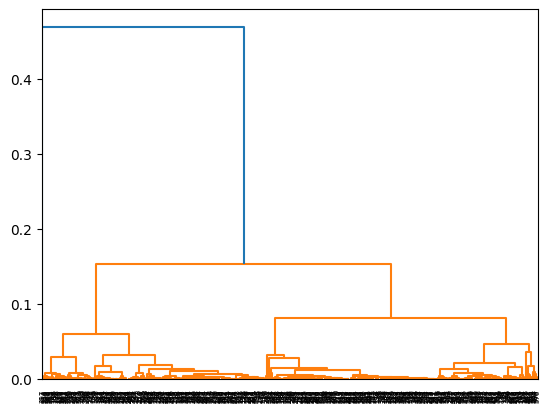

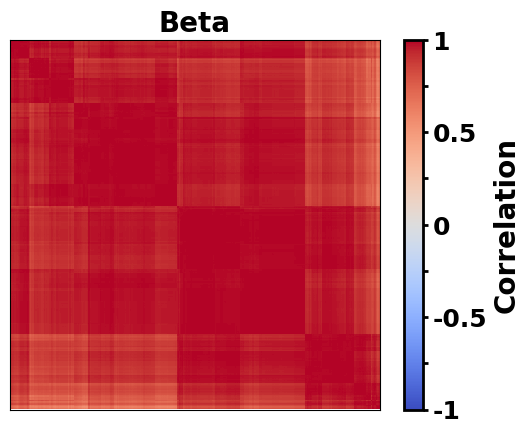

[2 1 2 1 1 1 3 1 1 1 1 2 1 3 3 1 2 1 2 2 3 3 2 2 3 2 1 2 1 3 1 1 2 2 3 1 1
 3 2 1 2 2 3 1 2 1 1 1 1 2 3 3 2 1 3 1 2 1 1 2 1 3 1 1 2 1 1 2 2 1 2 2 2 1
 1 1 3 2 1 1 1 2 2 1 2 1 3 1 1 3 2 2 1 2 1 2 1 3 1 1 2 1 2 2 2 2 1 3 2 1 2
 1 1 2 1 2 3 3 1 2 3 1 2 1 2 1 2 2 1 2 1 3 1 1 2 1 1 1 2 3 1 3 2 1 1 3 1 2
 3 1 1 1 1 1 1 1 2 1 1 3 2 2 1 1 2 3 1 2 1 1 1 1 1 3 1 2 3 1 2 1 3 2 2 1 2
 3 2 1 2 1 1 1 3 1 3 3 1 2 1 1 2 2 2 3 2 1 3 1 3 3 2 4 3 2 1 2 3 1 1 2 3 1
 2 2 2 3 2 1 1 2 1 2 3 1 1 1 2 2 1 2 2 2 1 2 3 3 2 1 2 1 1 2 1 2 2 2 1 2 2
 1 1 1 1 1 2 2 2 2 1 1 1 3 2 1 1 2 2 2 1 2 1 1 2 2 2 1 2 2 1 2 2 3 3 1 1 2
 1 1 2 1 3 3 3 2 3 1 1 1 3 3 1 2 3 2 1 3 2 1 2 2 2 1 3 3 1 2 1 2 3 3 1 3 3
 1 2 2 3 3 1 3 2 1 3 2 2 2 2 3 2 2 1 1 1 3 1 2 1 1 3 1 1 1 1 2 1 1 1 3 2 1
 1 1 1 1 1 2 2 1 1 2 2 2 2 1 2 2 1 1 1 2 2 1 1 3 2 1 1 1 2 1 1 1 3 2 2 2 3
 2 3 1 1 3 2 2 3 1 3 1 1 3 2 1 3 3 1 3 1 3 2 2 2 1 3 1 1 1 2 2 1 2 1 3 2 1
 3 1 1 3 2 1 1 1 2 2 3 1 1 1 2 1 2 1 2 3 3 1 2 2 1 3 2 3 1 1 1 2 1 1 1 2 1
 2 1 1 1 2 1 2 1 2 1 1 1 

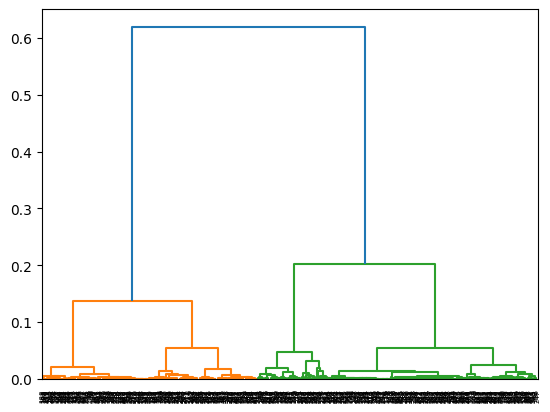

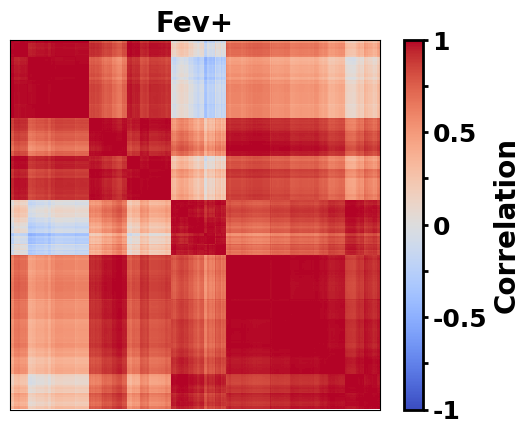

[4 3 4 4 2 3 2 4 4 3 4 1 3 1 4 4 2 2 2 4 4 4 1 1 1 4 3 1 4 2 2 1 1 4 1 4 4
 4 1 4 2 3 4 1 2 4 1 4 4 1 3 3 4 4 3 2 1 4 1 4 1 4 1 3 4 4 2 4 4 2 4 3 4 1
 4 1 1 3 4 4 2 4 2 4 2 2 4 4 1 3 4 3 1 3 1 4 1 1 3 4 1 4 1 2 2 3 2 2 4 2 3
 4 1 3 3 2 4 1 2 4 2 4 4 4 4 4 1 4 3 2 4 4 1 2 4 3 1 3 4 4 1 1 2 4 2 2 2 1
 1 4 4 2 4 2 4 2 4 1 3 3 1 2 2 1 2 4 4 4 3 4 1 4 4 4 3 1 2 4 1 1 4 4 1 1 2
 3 3 1 1 2 4 4 2 1 1 1 2 4 4 4 1 2 4 4 4 2 3 4 3 1 3 4 4 4 2 3 4 3 4 2 1 3
 4 1 4 2 4 1 4 1 2 1 2 4 4 1 4 1 3 4 4 4 1 2 4 3 3 4 2 4 4 4 3 4 4 4 2 3 4
 4 1 3 4 4 1 4 4 4 4 3 4 4 4 1 4 3 3 4 2 2 4 4 2 2 1 4 2 2 1 2 4 4 4 3 4 4
 3 2 4 3 4 4 4 4 2 3 2 4 2 2 2 3 4 4 4 3 2 2 2 4 4 1 4 4 2 3 4 1 1 3 4 1 1
 3 4 3 1 4 2 3 2 2 4 4 1 4 4 3 2 4 3 2 1 3 1 4 2 1 2 2 4 2 4 4 2 3 4 2 1 4
 4 4 2 2 2 4 3 1 3 4 1 3 2 4 3 2 1 2 4 1 2 4 4 2 1 4 1 1 1 4 4 2 4 3 4 2 4
 4 2 3 3 4 2 2 4 2 1 1 2 1 1 3 4 4 4 4 4 4 1 3 2 4 4 4 4 4 2 1 2 1 2 1 4 4
 2 4 4 4 3 4 4 4 1 4 2 1 3 4 4 1 3 1 4 1 1 4 1 4 1 1 4 4 4 4 4 4 2 2 1 2 4
 4 3 4 4 1 1 2 3 1 2 4 4 

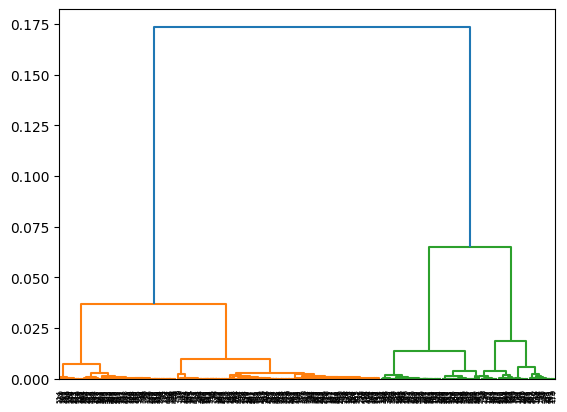

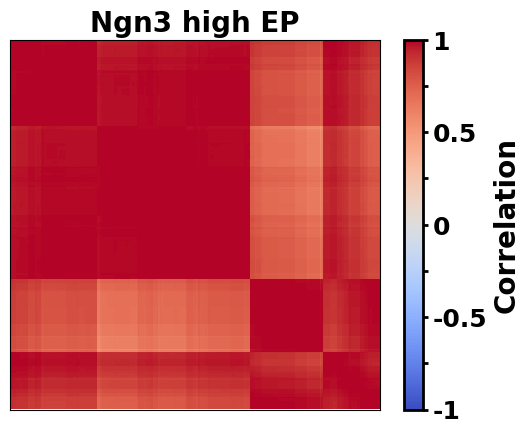

[1 2 2 1 1 2 1 1 1 2 2 1 1 2 1 2 2 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 1 1 1 1
 1 1 1 2 1 2 1 2 1 1 2 1 1 2 2 1 1 1 1 2 2 1 1 1 2 1 1 1 1 2 2 2 1 1 2 1 2
 2 1 1 2 1 1 2 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2 2 2 1 2 1 2
 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 2 1 2 2 1 2 2 2 1 1 1 1 1 2 1 1 2 1 1
 1 2 1 2 2 1 2 2 1 2 1 1 1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 1 1 2 1 2 1 2 1 2 1
 1 1 1 2 2 1 1 2 1 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 2 1 1 2 1 1 2 2 2 1 1
 1 1 1 2 2 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 2 1 1 1 2 1 1 1 1 2 1
 2 1 1 2 2 2 2 2 1 1 2 1 2 1 2 1 1 1 2 1 1 1 2 1 1 2 1 2 2 2 1 1 1 1 1 2 1
 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 2 2 2 2 1 2 1
 2 1 2 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 2 1 2
 2 1 2 2 2 2 2 1 1 1 2 2 1 2 1 2 2 1 1 1 2 2 2 2 1 1 2 2 1 1 2 2 1 1 1 1 2
 2 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 2 1 1 1 1 2 2 1 2 1 1 2 1 1 1 2 2 2 1 1 1 2 1 1 2 1 1 1 2 2 1 2 1 1 2 2
 1 2 2 1 1 1 1 1 1 2 2 2 

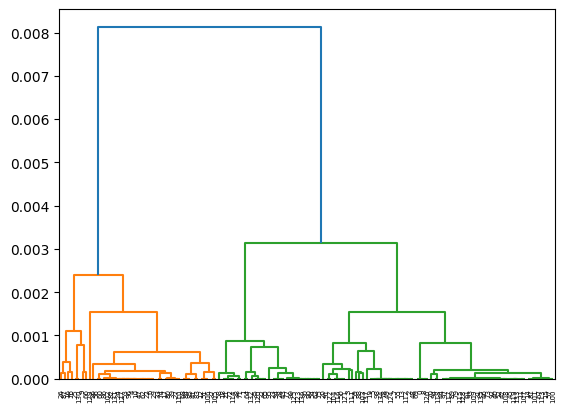

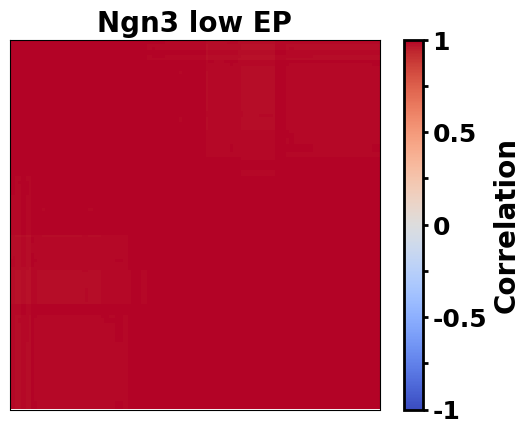

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [80]:
###After optimize the cosdistance. cluster threshold is t
from matplotlib.colors import Normalize                #⬇
t = 1 - np.cos(np.pi/8)#threshold                    自行选择
TT = {}
for i in range(len(categories)):
    cl_cat = categories[i]
    vec_corr = eigenvec[cl_cat]@eigenvec[cl_cat].T
    
    Z=linkage((1-vec_corr)[np.triu_indices(vec_corr.shape[0],k=1)],method='weighted')#method='weighted')
    dg=dendrogram(Z)
    #X_re= X[:,dg['leaves']]#X_re reorder X by clustering
    plt.show()
    
    vec_corr_re = vec_corr[dg['leaves'],:][:,dg['leaves']]
    plt.imshow(vec_corr_re, aspect='equal', cmap=plt.cm.coolwarm, interpolation='nearest',norm=Normalize(-1,1))
    plt.title(categories[i],fontsize=20,weight='bold')
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=12)
    cb.ax.tick_params(width=2)  # 设置刻度线宽度
    cb.outline.set_linewidth(2)  # 设置 colorbar 边框宽度
# 设置 colorbar 刻度字体和加粗
    for tick in cb.ax.get_yticklabels():
        tick.set_fontsize(18)  # 设置刻度标签字体大小
        tick.set_weight('bold')  # 设置刻度标签加粗
    # 设置 colorbar 的标题
    cb.set_ticklabels(['-1','', '-0.5', '','0','', '0.5','', '1'])  # 设置刻度标签
    cb.set_label('Correlation', fontsize=20, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(result_path+f'Corr_new of {categories[i]}.png')
    plt.show()

    # xcos = np.linspace(0,1,100)
    # plt.plot(xcos,gaussian_kde(vec_corr.flatten())(xcos))
    # plt.title(categories[i],fontsize=15,weight='bold')
    # plt.show()
    
    T = fcluster(Z, t=t, criterion='distance')
    print(T)

    TT[categories[i]] = T

5

cluster number of Alpha 4
num of 1 type in Alpha: 22
num of 2 type in Alpha: 229
num of 3 type in Alpha: 225
num of 4 type in Alpha: 1

cluster number of Beta 4
num of 1 type in Beta: 266
num of 2 type in Beta: 205
num of 3 type in Beta: 119
num of 4 type in Beta: 1

cluster number of Fev+ 4
num of 1 type in Fev+: 126
num of 2 type in Fev+: 130
num of 3 type in Fev+: 87
num of 4 type in Fev+: 244

cluster number of Ngn3 high EP 2
num of 1 type in Ngn3 high EP: 343
num of 2 type in Ngn3 high EP: 186

cluster number of Ngn3 low EP 1
num of 1 type in Ngn3 low EP: 138


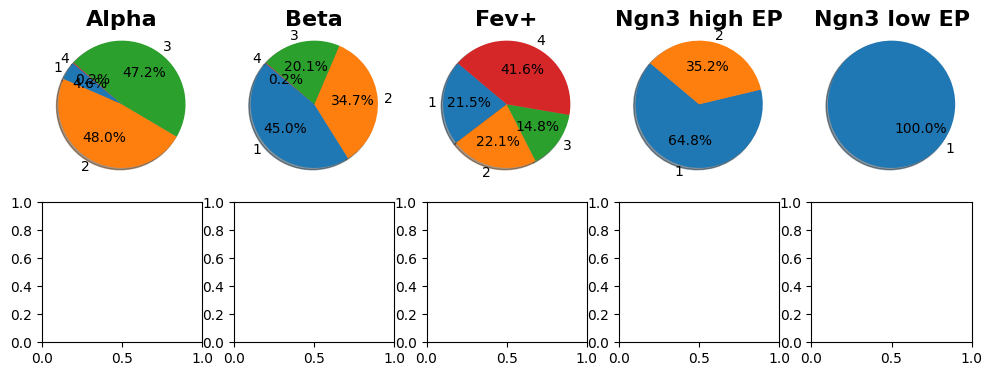

In [81]:
##聚类结果的饼图显示
print(len(categories))
row,col = 2,5
fig, axs = plt.subplots(row, col,figsize = (12,4))
k = 0
for i in categories:
    if i == 'Other Glia':
        continue
    print('')
    print(f'cluster number of {i}',len(set(TT[i])))
    for j in set(TT[i]):
        print(f'num of {j} type in {i}:',np.sum(TT[i] == j))
    axs[k//col,k%col].pie([np.sum(TT[i] == j) for j in set(TT[i])], labels=set(TT[i]), autopct='%1.1f%%', shadow=True, startangle=140)
    axs[k//col,k%col].axis('equal')  # 确保饼图是圆形的
    axs[k//col,k%col].set_title(f'{i}',fontsize=16,weight='bold')
    k+=1
# plt.title('Clustering of eigenvectors on different cell',fontsize=20,weight='bold')
plt.savefig(result_path+f'pie_eigenvector{t}.png')
plt.show()


plot the new vector

In [82]:
def plot3d(x1,x2,x3,color,color_bar_name='color_bar',save_name='3d.png'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
    cmap = plt.colormaps['Spectral']
    sc = ax.scatter(x1, x2, x3,  s=10, c=color,alpha=0.8,cmap=cmap)
    cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label(color_bar_name)
    plt.savefig(result_path+save_name)
    plt.show()

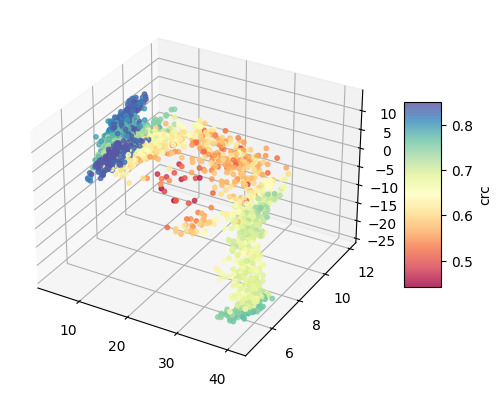

In [83]:
###CRC ON EMBEDDIGN
if L>2:
    max1,max2,max3 = np.argsort(np.mean(sigma_learned**2,axis=0))[-3:]
    plot3d(mu_learned[:,max1], mu_learned[:,max2], mu_learned[:,max3],
       color=crc_smooth,color_bar_name='crc',save_name=f'cl on embedding{K}_{L}.png')

In [84]:
##颜色
colors = [
    ('red', '#FF0000'),
    ('green', '#00FF00'),
    ('blue', '#0000FF'),
    ('black', '#000000'),
    ('lime', '#FFFFFF'),
    ('yellow', '#FFFF00'),
    ('cyan', '#00FFFF'),
    ('magenta', '#FF00FF'),
    ('orange', '#FFA500'),
    ('purple', '#800080'),
    ('tomato', '#808080'),
    ('steelblue','#4682b4'),
]

In [85]:
##移动之后的新向量，保存方法是字典
newvec={}
startvec={}
color_cl = {}
k=0
for i in categories:
    newvec[i] ,startvec[i] = [],[]
    color_cl[i] = colors[k][0]
    k+=1
    cell_i = np.mean(X[clusters==i],axis=0)
    for j in set(TT[i]):
        vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
        newvec[i].append(cell_i + 0.1*vec_j)
        startvec[i].append(cell_i)

In [86]:
##聚类颜色
color_cell = []
for i in range(len(X)):
    color_cell.append(color_cl[clusters[i]])

In [87]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
# cmap = plt.colormaps['Spectral']
# ax.scatter(mu_learned[:,max1], mu_learned[:,max2], mu_learned[:,max3],c='grey',s=1,alpha=0.02)
# for i in categories:
#     k=0
#     for j in newvec[i]:
#         if new_para_name == '':
#             embed_j = encoder(torch.tensor(j.astype(np.float32)))
#             embed_j_mu = embed_j[0].detach().numpy()
#         else:
#             embed_j_mu = encoder(torch.tensor(j.astype(np.float32)))[:L].detach().numpy()
#         ax.scatter(embed_j_mu[max1], embed_j_mu[max2], embed_j_mu[max3], c=color_cl[i], s=60,alpha=1,cmap=cmap,
#                    label = i if k==0 else None)
#         k+=1
# plt.legend(loc='upper left', fontsize=8)
# plt.savefig(result_path+'3d_eigenvector.png')
# plt.show()

In [88]:
####cluster内整体正负号调整
newvec={}
k=0
for i in categories:
    newvec[i]  = []
    k+=1
    cell_i = np.mean(X[clusters==i],axis=0)
    for j in set(TT[i]):
        vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
        if i in ['Nbl2','ImmGranule2','CA','RadialGlia','RadialGlia2']:
            vec_j = -vec_j
        newvec[i].append(cell_i + 0.1*vec_j)
    newvec[i] = np.array(newvec[i])

In [89]:
import umap
trans = umap.UMAP(n_neighbors=20, random_state=42).fit(X)

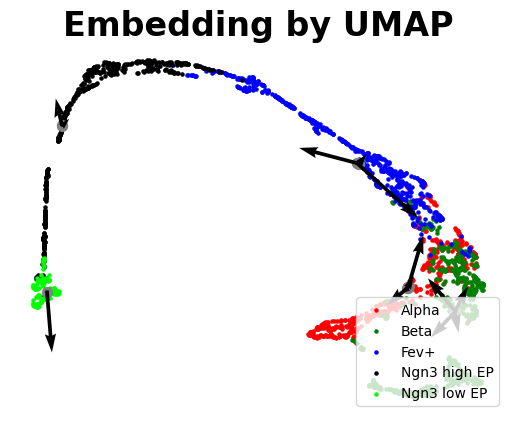

In [90]:
np.random.seed(42)
for i in categories:
    plt.scatter(trans.embedding_[clusters==i, 0], trans.embedding_[clusters==i, 1], s= 5,c = color_cl[i],
                cmap='Spectral',label=f'{i}')
for i in newvec:
    start_embedding = trans.transform(np.vstack(startvec[i]))
    test_embedding = trans.transform(np.vstack(newvec[i]))
    plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
    plt.quiver(start_embedding[:, 0], start_embedding[:, 1],
               test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
               scale=1)
plt.title('Embedding by UMAP', fontsize=24,weight='bold')
plt.legend(loc='lower right')
plt.axis('off')
plt.savefig(result_path+'umap_eigenvector.png')
plt.show()

In [91]:
########machine learning for TSNE
#------use a simple neural network to study dmu/dt and dsigma/dt

model = nn.Sequential(
    nn.Linear(X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x_in=torch.tensor(X.astype(np.float32))
x_out=torch.tensor(np.vstack((X_plt,Y_plt)).T.astype(np.float32))
# Train the model
for epoch in range(300):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    if epoch% 10 == 9:
        print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


9 tensor(21.0217, grad_fn=<MseLossBackward0>)
19 tensor(9.2706, grad_fn=<MseLossBackward0>)
29 tensor(4.4639, grad_fn=<MseLossBackward0>)
39 tensor(3.2088, grad_fn=<MseLossBackward0>)
49 tensor(2.1645, grad_fn=<MseLossBackward0>)
59 tensor(1.7366, grad_fn=<MseLossBackward0>)
69 tensor(1.5497, grad_fn=<MseLossBackward0>)
79 tensor(1.4383, grad_fn=<MseLossBackward0>)
89 tensor(1.3467, grad_fn=<MseLossBackward0>)
99 tensor(1.2836, grad_fn=<MseLossBackward0>)
109 tensor(1.2388, grad_fn=<MseLossBackward0>)
119 tensor(1.2050, grad_fn=<MseLossBackward0>)
129 tensor(1.1799, grad_fn=<MseLossBackward0>)
139 tensor(1.1601, grad_fn=<MseLossBackward0>)
149 tensor(1.1436, grad_fn=<MseLossBackward0>)
159 tensor(1.1291, grad_fn=<MseLossBackward0>)
169 tensor(1.1162, grad_fn=<MseLossBackward0>)
179 tensor(1.1046, grad_fn=<MseLossBackward0>)
189 tensor(1.0942, grad_fn=<MseLossBackward0>)
199 tensor(1.0844, grad_fn=<MseLossBackward0>)
209 tensor(1.0750, grad_fn=<MseLossBackward0>)
219 tensor(1.0658, grad

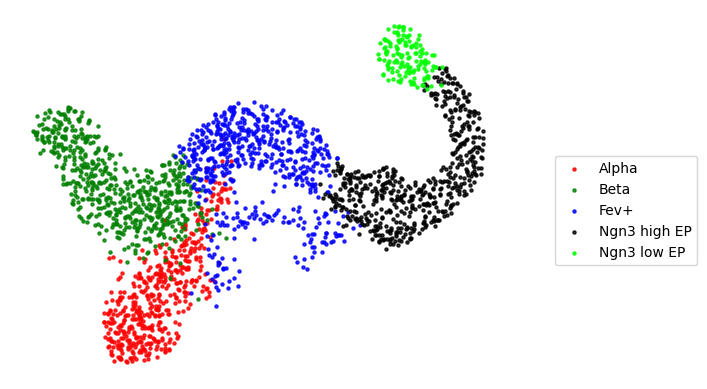

In [92]:
np.random.seed(42)
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 5,c = color_cl[i],alpha=0.8,
                cmap='Spectral',label=f'{i}')
# for i in newvec:
#     start_embedding = model(torch.tensor(startvec[i])).detach().numpy()
#     test_embedding = model(torch.tensor(newvec[i].astype(np.float32))).detach().numpy()
#     #plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
#     plt.quiver(start_embedding[:, 0], start_embedding[:, 1],
#                test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
#                scale=0.3)
# plt.title('Embedding by TSNE', fontsize=24)
plt.legend(bbox_to_anchor=(1.4,0.29),loc='lower right')
plt.axis('off')
plt.savefig(result_path+'TSNE_eigenvector.png',bbox_inches='tight')
plt.show()

In [93]:
## 饼图的结果对原本cluster再细分
clusters_mine = []
ktime = {}
for k,i in enumerate(clusters):
    if i in ktime:
        ktime[i] = ktime[i]+1
    else:
        ktime[i] = 0
    clusters_mine.append(f'{i}_{TT[i][ktime[i]]}')
clusters_mine = np.array(clusters_mine)

In [94]:
colors_hex = [
    "#FF5733", "#FFBD33", "#FFC300", "#DAFF33", "#33FF57", 
    "#33FFBD", "#33C1FF", "#337BFF", "#335BFF", "#5733FF", 
    "#BD33FF", "#FF33F6", "#FF33A1", "#FF335B", "#FF5733", 
    "#FF8D33", "#FF3333", "#FF6633", "#FF9933", "#FFFF33", 
    "#BFFF33", "#33FF8D", "#33FF99", "#33FFFF", "#3399FF", 
    "#3366FF", "#6633FF", "#9933FF", "#FF33C4", "#FF33A1", 
    "#FF5733", "#FF8D33"
]

# 转换为NumPy数组
colors_np = np.array(colors_hex)

# 打印结果
print(colors_np)

['#FF5733' '#FFBD33' '#FFC300' '#DAFF33' '#33FF57' '#33FFBD' '#33C1FF'
 '#337BFF' '#335BFF' '#5733FF' '#BD33FF' '#FF33F6' '#FF33A1' '#FF335B'
 '#FF5733' '#FF8D33' '#FF3333' '#FF6633' '#FF9933' '#FFFF33' '#BFFF33'
 '#33FF8D' '#33FF99' '#33FFFF' '#3399FF' '#3366FF' '#6633FF' '#9933FF'
 '#FF33C4' '#FF33A1' '#FF5733' '#FF8D33']


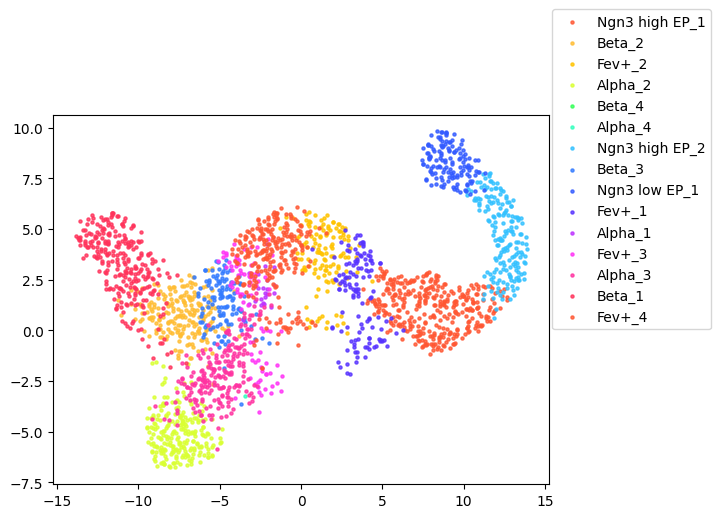

In [104]:
np.random.seed(42)
for k,i in enumerate(set(clusters_mine)):
    print()
    plt.scatter(X_plt[clusters_mine==i],Y_plt[clusters_mine==i], s= 5,c = colors_np[k],alpha=0.8,
                cmap='Spectral',label=f'{i}')
# for i in newvec:
#     start_embedding = model(torch.tensor(startvec[i])).detach().numpy()
#     test_embedding = model(torch.tensor(newvec[i].astype(np.float32))).detach().numpy()
#     #plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
#     plt.quiver(start_embedding[:, 0], start_embedding[:, 1],
#                test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
#                scale=0.3)
# plt.title('Embedding by TSNE', fontsize=24)
plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.savefig(result_path+'clusters_mine.png',bbox_inches='tight')
plt.show()

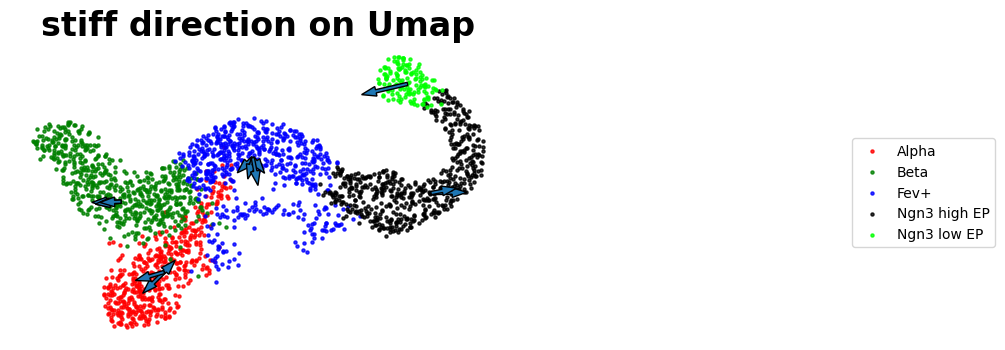

In [96]:
## 在cluster平均点画箭头

np.random.seed(42)
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 5,c = color_cl[i],alpha=0.8,
                cmap='Spectral',label=f'{i}')
for i in newvec:
    start_embedding = model(torch.tensor(startvec[i])).detach().numpy()
    test_embedding = model(torch.tensor(newvec[i].astype(np.float32))).detach().numpy()
    for j in range(len(set(TT[i]))):
        if np.sum(TT[i]==list(set(TT[i]))[j])/len(TT[i])<0.01:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i]==list(set(TT[i]))[j])*len(TT[i])
    #plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
        plt.arrow(start_embedding[j, 0], start_embedding[j, 1],
                (test_embedding[j, 0] - start_embedding[j, 0])/lenvecj*2,
                (test_embedding[j, 1] - start_embedding[j, 1])/lenvecj*2,width=0.2)
plt.title('stiff direction on Umap', fontsize=24,weight='bold')
plt.gca().set_aspect('equal')
plt.axis('off')
plt.legend(bbox_to_anchor=(2,0.29),loc='lower right')
# plt.savefig(result_path+'TSNE_eigenvector.png')
plt.show()

In [97]:
np.vstack((X_plt,Y_plt)).T.shape

(2322, 2)

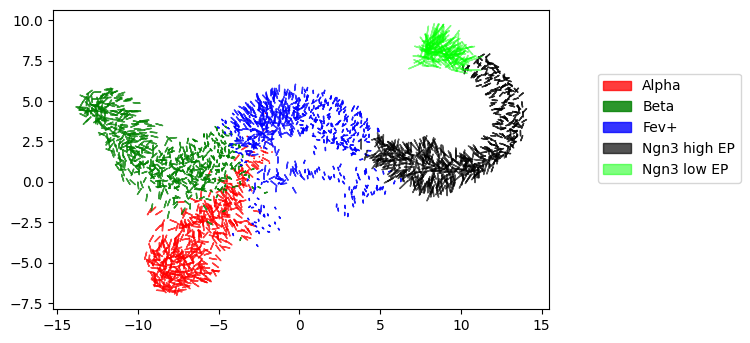

In [98]:
##箭头图
for i in categories:
    # start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
    start_embedding = np.vstack((X_plt,Y_plt)).T[clusters==i]
    test_embedding = model(torch.tensor(X[clusters==i]+eigenvec[i].astype(np.float32))).detach().numpy()
    if i in ['5','7','11']:
        test_embedding = model(torch.tensor(X[clusters==i]-eigenvec[i].astype(np.float32))).detach().numpy()
    # plt.quiver(0, 0,
    #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
    #            scale=0.3)
    # plt.title('Embedding by TSNE', fontsize=24)
    # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
    # plt.savefig(result_path+'TSNE_eigenvector.png')
    # plt.show()

    for j in range(len(start_embedding)):
        if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.01:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(start_embedding[j,0],start_embedding[j,1],
                  (test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                  color=color_cl[i],alpha=1-0.5*np.sum(TT[i] == TT[i][j])/len(TT[i]),
                  label=f'{i}' if j==0 else None)
        
    #plt.title(i,fontsize=15,weight='bold')
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.4,0.4),loc='lower right')
plt.show()

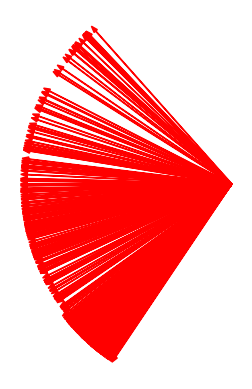

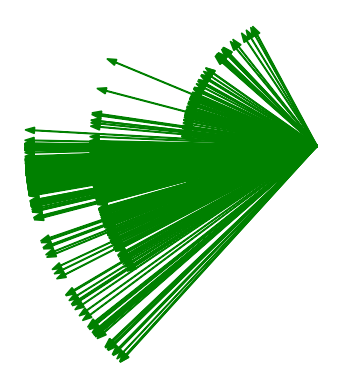

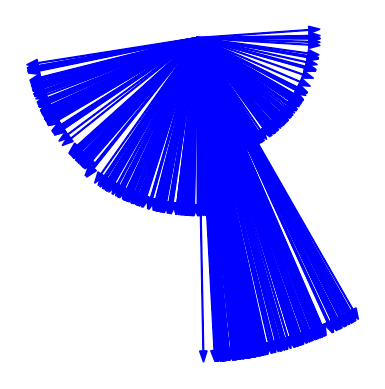

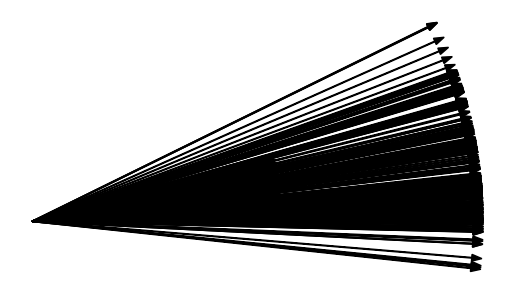

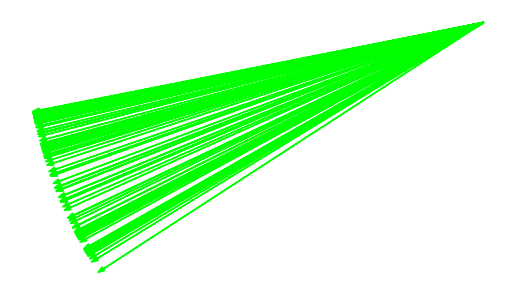

In [99]:
#####神经网络得到可视化的箭头
for i in categories:
    start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
    test_embedding = model(torch.tensor(X[clusters==i]+eigenvec[i].astype(np.float32))).detach().numpy()
    if i in ['5','7','11']:
        test_embedding = model(torch.tensor(X[clusters==i]-eigenvec[i].astype(np.float32))).detach().numpy()
    # plt.quiver(0, 0,
    #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
    #            scale=0.3)
    # plt.title('Embedding by TSNE', fontsize=24)
    # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
    # plt.savefig(result_path+'TSNE_eigenvector.png')
    # plt.show()

    for j in range(len(start_embedding)):
        if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.05:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(0,0,(test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                  color=color_cl[i],head_width=0.01,
                  label=f'{i}' if j==0 else None)
        
    #plt.title(i,fontsize=15,weight='bold')
    plt.gca().set_aspect('equal')
    # plt.legend()
    plt.axis('off')
    plt.savefig(result_path+f'arrow of {i}.png')
    plt.show()

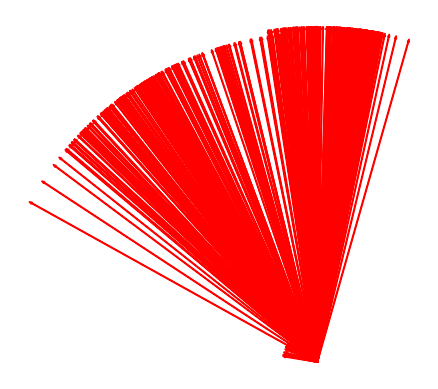

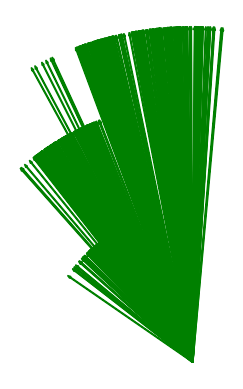

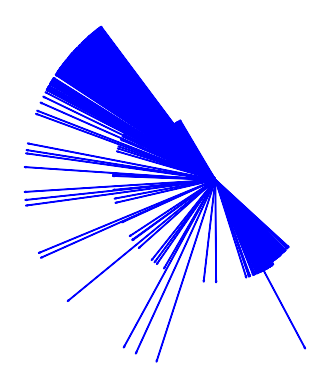

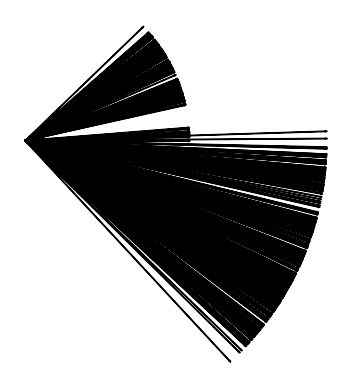

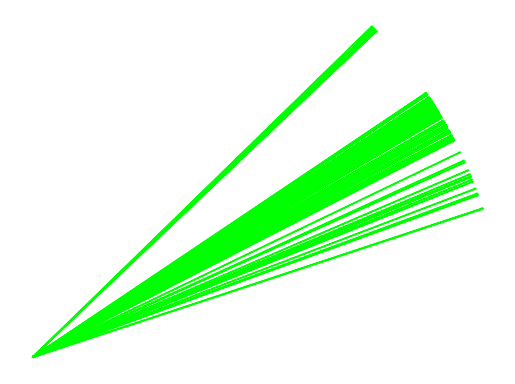

In [100]:
###umap函数得到可视化的箭头
for i in categories:
    start_embedding = trans.transform(X[clusters==i])
    test_embedding = trans.transform(eigenvec[i])
    # plt.quiver(0, 0,
    #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
    #            scale=0.3)
    # plt.title('Embedding by TSNE', fontsize=24)
    # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
    # plt.savefig(result_path+'TSNE_eigenvector.png')
    # plt.show()

    for j in range(len(start_embedding)):
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(0,0,(test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                  color=color_cl[i],label=f'{i}' if j==0 else None)
        
    #plt.title(i,fontsize=15,weight='bold')
    plt.gca().set_aspect('equal')
    # plt.legend()
    plt.axis('off')
    plt.savefig(result_path+f'zzzUmap_arrow of {i}.png')
    plt.show()

In [101]:
## Total variance
for i in categories:
    vec_corr = eigenvec[i]@eigenvec[i].T
    print(np.trace(vec_corr))

477.0
591.0
587.0
529.0
138.0


In [102]:
###cosdistance
for part in [3,4,6,10,18,8]:
    print(1-np.cos(np.pi/part))

0.4999999999999999
0.2928932188134524
0.1339745962155613
0.04894348370484647
0.01519224698779198
0.07612046748871326


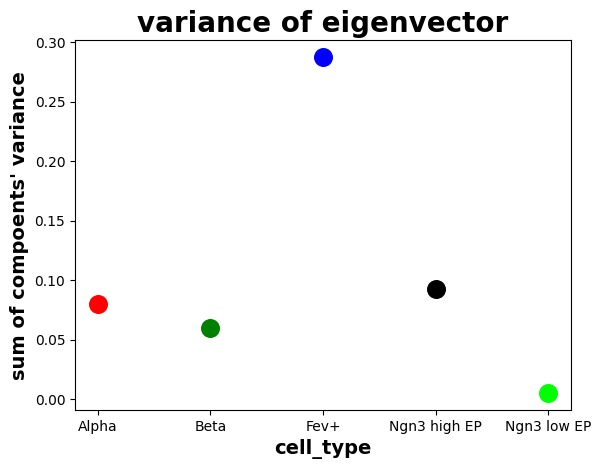

In [103]:
#variance of parameter velocity
k=0
if 'Other Glia' in categories:
    categories_new=np.delete(categories, np.where(categories == 'Other Glia'))
else:
    categories_new = categories
for i in categories_new:
    # vec_corr = eigenvec[i]@eigenvec[i].T
    # plt.scatter(k,np.trace(vec_corr),label=i,s=10)
    plt.scatter(k,np.sum(np.var(eigenvec[i],axis=0)),label=i,s=160,c=color_cl[i])
    k+=1
plt.title('variance of eigenvector', fontsize=20,weight='bold')
plt.xticks(range(len(categories_new)),categories_new)
if np.sum([len(i) for i in categories_new])>50:
    plt.xticks(rotation=40)
# plt.legend()

plt.xlabel('cell_type',fontsize=14,weight='bold')
plt.ylabel("sum of compoents' variance",fontsize=14,weight='bold')
plt.savefig(result_path+f'variance of eigenvec',dpi=300, bbox_inches='tight')
plt.show()

## loop
###### 遍历饼图的聚类阈值，可以不跑

In [ ]:
uppart = 100
for part in [3,4,6,10,18,8]:
    if part > uppart:
        continue
    t = 1 - np.cos(np.pi/part)#threshold
    TT = {}
    for i in range(len(categories)):
        cl_cat = categories[i]
        vec_corr = eigenvec[cl_cat]@eigenvec[cl_cat].T
        
        Z=linkage((1-vec_corr)[np.triu_indices(vec_corr.shape[0],k=1)],method='weighted')#method='weighted')
        dg=dendrogram(Z)
        #X_re= X[:,dg['leaves']]#X_re reorder X by clustering
        plt.close()
        
        vec_corr_re = vec_corr[dg['leaves'],:][:,dg['leaves']]
        plt.imshow(vec_corr_re, aspect='equal', cmap=plt.cm.coolwarm, interpolation='nearest',norm=Normalize(-1,1))
        plt.title(categories[i],fontsize=20,weight='bold')
        cb=plt.colorbar()
        cb.ax.tick_params(labelsize=12)
        cb.ax.tick_params(width=2)  # 设置刻度线宽度
        cb.outline.set_linewidth(2)  # 设置 colorbar 边框宽度
    # 设置 colorbar 刻度字体和加粗
        for tick in cb.ax.get_yticklabels():
            tick.set_fontsize(18)  # 设置刻度标签字体大小
            tick.set_weight('bold')  # 设置刻度标签加粗
        # 设置 colorbar 的标题
        cb.set_ticklabels(['-1','', '-0.5', '','0','', '0.5','', '1'])  # 设置刻度标签
        cb.set_label('Correlation', fontsize=20, fontweight='bold')
        plt.xticks([])
        plt.yticks([])
        plt.savefig(result_path+f'Corr_new of {categories[i]}.png')
        plt.close()

        # xcos = np.linspace(0,1,100)
        # plt.plot(xcos,gaussian_kde(vec_corr.flatten())(xcos))
        # plt.title(categories[i],fontsize=15,weight='bold')
        # plt.show()
        
        T = fcluster(Z, t=t, criterion='distance')
        print(T)

        TT[categories[i]] = T

    print('cluster个数：',len(categories))
    row,col = 2,5
    fig, axs = plt.subplots(row, col,figsize = (12,4))
    k = 0
    for i in categories:
        if i == 'Other Glia':
            continue
        print('')
        print(f'cluster number of {i}',len(set(TT[i])))
        for j in set(TT[i]):
            print(f'num of {j} type in {i}:',np.sum(TT[i] == j))
        axs[k//col,k%col].pie([np.sum(TT[i] == j) for j in set(TT[i])], labels=set(TT[i]), autopct='%1.1f%%', shadow=True, startangle=140)
        axs[k//col,k%col].axis('equal')  # 确保饼图是圆形的
        axs[k//col,k%col].set_title(f'{i}',fontsize=16,weight='bold')
        k+=1
    # plt.title('Clustering of eigenvectors on different cell',fontsize=20,weight='bold')
    plt.savefig(result_path+f'pie_eigenvector{t}.png')
    plt.close()

    if np.max([len(set(TT[i])) for i in TT]) > 30:
        uppart = part
        continue
    

    def plot3d(x1,x2,x3,color,color_bar_name='color_bar',save_name='3d.png'):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
        cmap = plt.colormaps['Spectral']
        sc = ax.scatter(x1, x2, x3,  s=10, c=color,alpha=0.8,cmap=cmap)
        cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
        cbar.set_label(color_bar_name)
        plt.savefig(result_path+save_name)
        plt.close()

    ###CRC ON EMBEDDIGN
    if L>2:
        max1,max2,max3 = np.argsort(np.mean(sigma_learned**2,axis=0))[-3:]
        plot3d(mu_learned[:,max1], mu_learned[:,max2], mu_learned[:,max3],
        color=crc_smooth,color_bar_name='crc',save_name=f'cl on embedding{K}_{L}.png')

    colors = [
        ('red', '#FF0000'),
        ('green', '#00FF00'),
        ('blue', '#0000FF'),
        ('black', '#000000'),
        ('lime', '#FFFFFF'),
        ('yellow', '#FFFF00'),
        ('cyan', '#00FFFF'),
        ('magenta', '#FF00FF'),
        ('orange', '#FFA500'),
        ('purple', '#800080'),
        ('tomato', '#808080'),
        ('steelblue','#4682b4'),
    ]

    newvec={}
    startvec={}
    color_cl = {}
    k=0
    for i in categories:
        newvec[i] ,startvec[i] = [],[]
        color_cl[i] = colors[k][0]
        k+=1
        cell_i = np.mean(X[clusters==i],axis=0)
        for j in set(TT[i]):
            vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
            newvec[i].append(cell_i + 0.1*vec_j)
            startvec[i].append(cell_i)

    color_cell = []
    for i in range(len(X)):
        color_cell.append(color_cl[clusters[i]])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
    cmap = plt.colormaps['Spectral']
    ax.scatter(mu_learned[:,max1], mu_learned[:,max2], mu_learned[:,max3],c='grey',s=1,alpha=0.02)
    for i in categories:
        k=0
        for j in newvec[i]:
            if new_para_name == '':
                embed_j = encoder(torch.tensor(j.astype(np.float32)))
                embed_j_mu = embed_j[0].detach().numpy()
            else:
                embed_j_mu = encoder(torch.tensor(j.astype(np.float32)))[:L].detach().numpy()
            ax.scatter(embed_j_mu[max1], embed_j_mu[max2], embed_j_mu[max3], c=color_cl[i], s=60,alpha=1,cmap=cmap,
                    label = i if k==0 else None)
            k+=1
    plt.legend(loc='upper left', fontsize=8)
    plt.savefig(result_path+'3d_eigenvector.png')
    plt.close()

    ####cluster内整体正负号调整
    newvec={}
    k=0
    for i in categories:
        newvec[i]  = []
        k+=1
        cell_i = np.mean(X[clusters==i],axis=0)
        for j in set(TT[i]):
            vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
            if i in ['Nbl2','ImmGranule2','CA','RadialGlia','RadialGlia2']:
                vec_j = -vec_j
            newvec[i].append(cell_i + 0.001*vec_j)
        newvec[i] = np.array(newvec[i])

    trans = umap.UMAP(n_neighbors=20, random_state=42).fit(X)
    np.random.seed(42)
    for i in categories:
        plt.scatter(trans.embedding_[clusters==i, 0], trans.embedding_[clusters==i, 1], s= 5,c = color_cl[i],
                    cmap='Spectral',label=f'{i}')
    for i in newvec:
        start_embedding = trans.transform(np.vstack(startvec[i]))
        test_embedding = trans.transform(np.vstack(newvec[i]))
        plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
        plt.quiver(start_embedding[:, 0], start_embedding[:, 1],
                test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
                scale=1)
    plt.title('Embedding by UMAP', fontsize=24,weight='bold')
    plt.legend(loc='lower right')
    plt.axis('off')
    plt.savefig(result_path+'umap_eigenvector.png')
    plt.close()

    ########machine learning for TSNE
    #------use a simple neural network to study dmu/dt and dsigma/dt

    model = nn.Sequential(
        nn.Linear(X.shape[1], 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,2),
    )

    # Define your loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    x_in=torch.tensor(X.astype(np.float32))
    x_out=torch.tensor(np.vstack((X_plt,Y_plt)).T.astype(np.float32))
    # Train the model
    for epoch in range(300):  # number of epochs
        # Forward pass
        output = model(x_in)
        loss = loss_fn(output,x_out)
        if epoch% 50 == 9:
            print(epoch,loss)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    np.random.seed(42)
    for i in categories:
        plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 5,c = color_cl[i],alpha=0.8,
                    cmap='Spectral',label=f'{i}')
    for i in newvec:
        start_embedding = model(torch.tensor(startvec[i])).detach().numpy()
        test_embedding = model(torch.tensor(newvec[i].astype(np.float32))).detach().numpy()
        for j in range(len(set(TT[i]))):
            if np.sum(TT[i]==list(set(TT[i]))[j])/len(TT[i])<0.01:
                continue
            lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i]==list(set(TT[i]))[j])*len(TT[i])
        #plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
            plt.arrow(start_embedding[j, 0], start_embedding[j, 1],
                    (test_embedding[j, 0] - start_embedding[j, 0])/lenvecj*2,
                    (test_embedding[j, 1] - start_embedding[j, 1])/lenvecj*2,width=0.2)
    plt.title('stiff direction on Umap', fontsize=24,weight='bold')
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.legend(bbox_to_anchor=(2,0.29),loc='lower right')
    # plt.savefig(result_path+'TSNE_eigenvector.png')
    plt.close()

    for i in categories:
        start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
        test_embedding = model(torch.tensor(X[clusters==i]+eigenvec[i].astype(np.float32))).detach().numpy()
        if i in ['5','7','11']:
            test_embedding = model(torch.tensor(X[clusters==i]-eigenvec[i].astype(np.float32))).detach().numpy()
        # plt.quiver(0, 0,
        #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
        #            scale=0.3)
        # plt.title('Embedding by TSNE', fontsize=24)
        # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
        # plt.savefig(result_path+'TSNE_eigenvector.png')
        # plt.show()

        for j in range(len(start_embedding)):
            if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.01:
                if j != 0:
                    continue
            lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
            plt.arrow(start_embedding[j,0],start_embedding[j,1],
                    (test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                    (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                    color=color_cl[i],alpha=1-0.5*np.sum(TT[i] == TT[i][j])/len(TT[i]),
                    label=f'{i}' if j==0 else None)
            
        #plt.title(i,fontsize=15,weight='bold')
    plt.gca().set_aspect('equal')
    plt.legend(bbox_to_anchor=(1.4,0.4),loc='lower right')
    plt.close()

    for i in categories:
        start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
        test_embedding = model(torch.tensor(X[clusters==i]+eigenvec[i].astype(np.float32))).detach().numpy()
        if i in ['5','7','11']:
            test_embedding = model(torch.tensor(X[clusters==i]-eigenvec[i].astype(np.float32))).detach().numpy()
        # plt.quiver(0, 0,
        #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
        #            scale=0.3)
        # plt.title('Embedding by TSNE', fontsize=24)
        # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
        # plt.savefig(result_path+'TSNE_eigenvector.png')
        # plt.show()

        for j in range(len(start_embedding)):
            if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.05:
                continue
            lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
            plt.arrow(0,0,(test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                    (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                    color=color_cl[i],head_width=0.01,
                    label=f'{i}' if j==0 else None)
            
        #plt.title(i,fontsize=15,weight='bold')
        plt.gca().set_aspect('equal')
        # plt.legend()
        plt.axis('off')
        plt.savefig(result_path+f'arrow of {i}.png')
        plt.close()

    for i in categories:
        start_embedding = trans.transform(X[clusters==i])
        test_embedding = trans.transform(eigenvec[i])
        # plt.quiver(0, 0,
        #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
        #            scale=0.3)
        # plt.title('Embedding by TSNE', fontsize=24)
        # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
        # plt.savefig(result_path+'TSNE_eigenvector.png')
        # plt.show()

        for j in range(len(start_embedding)):
            lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
            plt.arrow(0,0,(test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                    (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                    color=color_cl[i],label=f'{i}' if j==0 else None)
            
        #plt.title(i,fontsize=15,weight='bold')
        plt.gca().set_aspect('equal')
        # plt.legend()
        plt.axis('off')
        plt.savefig(result_path+f'zzzUmap_arrow of {i}.png')
        plt.close()


    #variance of parameter velocity
    k=0
    if 'Other Glia' in categories:
        categories_new=np.delete(categories, np.where(categories == 'Other Glia'))
    else:
        categories_new = categories
    for i in categories_new:
        # vec_corr = eigenvec[i]@eigenvec[i].T
        # plt.scatter(k,np.trace(vec_corr),label=i,s=10)
        plt.scatter(k,np.sum(np.var(eigenvec[i],axis=0)),label=i,s=160,c=color_cl[i])
        k+=1
    plt.title('variance of eigenvector', fontsize=20,weight='bold')
    plt.xticks(range(len(categories_new)),categories_new)
    if np.sum([len(i) for i in categories_new])>50:
        plt.xticks(rotation=40)
    # plt.legend()

    plt.xlabel('cell_type',fontsize=14,weight='bold')
    plt.ylabel("sum of compoents' variance",fontsize=14,weight='bold')
    plt.savefig(result_path+f'variance of eigenvec',dpi=300, bbox_inches='tight')
    plt.close()